In [1]:
import graph_tool.all as gt
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson
from graph_tool.all import *
import random
import os
from tqdm import tqdm
import matplotlib.image as mpimg
import pandas as pd
from PyGnuplot import gp
import subprocess

In [2]:
n = 10000

M = 5

times = 100

beta_list = [1,1/2,0]

#net_list = ["SF", "Cutoff", "RA"]
net_list = ["IPA_beta1", "IPA_beta3","IPA_beta5","IPA_beta100"]

#name_list = ["v=1", "v=1/2", "v=0"]
name_list = ["v=-1", "v=-3", "v=-5", "v=-100"]

In [3]:
average_degree = []
k_value_list = []
for net in net_list:
    degree_dist_list = []
    for i in range(times):
        
        g = load_graph(f"~/o_t_hayashilab/Network_data/graph-tool/modular_structure/{net}/w=0.00/m0={M}/{i}.gt.gz")
                       
        degrees = g.degree_property_map("total").a
        degree_hist, bin_edges = np.histogram(degrees, bins=np.arange(np.max(degrees) + 2))
        k = bin_edges[:-1]
        degree_dist = degree_hist / n
        # Storing degree distribution in a list
        degree_dist_list.append(degree_dist)
        
    max_len = max(len(lst) for lst in degree_dist_list)

    average_degree_dist = [
        np.mean([lst[i] if i < len(lst) else 0 for lst in degree_dist_list])
        for i in range(max_len)
    ]

    k_values = np.arange(max_len)
    
    average_degree.append(average_degree_dist)
    k_value_list.append(k_values)

In [4]:
# Gnuplotを使って次数分布をプロット
for i in range(len(net_list)):
    # Gnuplotにデータを渡すための一時ファイルを作成
    data_file = f'/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/degree_distribution_net_{net_list[i]}.dat'
    
    # データを一時ファイルに書き込む
    with open(data_file, 'w') as f:
        for j in range(len(k_value_list[i])):
            f.write(f'{k_value_list[i][j]}\t{average_degree[i][j]}\n')
    
    # Gnuplotスクリプトを作成
    gnuplot_script = (
        "set terminal png\n"
        f"set output '/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/P(k)_N10000_{net}_net_{net_list[i]}.png'\n"
        f"set title 'degree-distribution (net = {net_list[i]})'\n"
        "set xlabel 'k'\n"
        "set ylabel 'P(k)'\n"
        "set logscale # 両対数グラフにする\n"
        "set format x '10^{{%L}}'  # x軸の目盛りを指数表記にする\n"
        "set format y '10^{{%L}}'  # y軸の目盛りを指数表記にする\n"
        f"plot '{data_file}' with linespoints title 'degree-distribution'\n"
    )

    # Gnuplotスクリプトをファイルに保存
    gnuplot_script_file = f'/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/gnuplot_script_net_{net_list[i]}.plt'
    with open(gnuplot_script_file, 'w') as f:
        f.write(gnuplot_script)

    # Gnuplotをスクリプトファイルで実行
    subprocess.run(["gnuplot", gnuplot_script_file])

    # 一時ファイルを削除
    #os.remove(data_file)
    #os.remove(gnuplot_script_file)

In [5]:
gnuplot_script = (
    "set terminal png size 1000,1200\n"
    f"set output '/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/P(k)_m0={M}.png'\n"
    "set xlabel 'k' font ',40' offset 0,-2\n"
    "set ylabel 'P(k)' font ',40' rotate by 360 offset -9,0\n"
    "set logscale\n"
    "set format x '10^{{%L}}'\n"
    "set format y '10^{{%L}}'\n"
    "set key font ',40'\n"
    "set xtics font ',30' offset 0,-2\n"
    "set ytics font ',30' offset -1,-1.5\n"
    "set lmargin 20\n"
)

# 各w毎のデータを1つのプロットに結合
plot_command = "plot "
for i in range(len(net_list)):
    data_file = f'/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/degree_distribution_net_{net_list[i]}.dat'
    
    # 色の設定
    color = ["red", "orange", "yellow"][i]
    
    # 点の形状の設定
    point_type = [12, 10, 8][i]
    
    # 点の大きさと線の太さの設定
    point_size = 1.8  # 点の大きさを1.5倍に
    line_width = 1.8   # 線の太さを2倍に
    
    plot_command += f"'{data_file}' with linespoints title '{name_list[i]}' lt {i+1} lc rgb '{color}' pt {point_type} ps {point_size} lw {line_width}, "

# Gnuplotスクリプトの末尾の不要なカンマを削除
plot_command = plot_command.rstrip(', ')
gnuplot_script += plot_command

# Gnuplotスクリプトをファイルに保存
gnuplot_script_file = '/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/gnuplot_script_combined.plt'
with open(gnuplot_script_file, 'w') as f:
    f.write(gnuplot_script)

# Gnuplotをスクリプトファイルで実行
subprocess.run(["gnuplot", gnuplot_script_file])

# 一時ファイルを削除
for i in range(len(net_list)):
    data_file = f'/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/degree_distribution_net_{net_list[i]}.dat'
    os.remove(data_file)
os.remove(gnuplot_script_file)

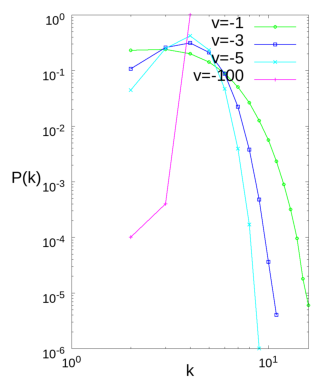

In [6]:
# PNG画像の読み込み
image_path = f"/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/P(k)_m0={M}.png"  # 画像のパスを指定してください
image = mpimg.imread(image_path)

# 画像の表示
plt.imshow(image)
plt.axis('off')  # 軸を非表示にする
plt.show()

In [4]:
# Gnuplotを使って次数分布をプロット
for i in range(len(net_list)):
    # Gnuplotにデータを渡すための一時ファイルを作成
    data_file = f'/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/degree_distribution_net_{net_list[i]}.dat'
    
    # データを一時ファイルに書き込む
    with open(data_file, 'w') as f:
        for j in range(len(k_value_list[i])):
            f.write(f'{k_value_list[i][j]}\t{average_degree[i][j]}\n')
    
    # Gnuplotスクリプトを作成
    gnuplot_script = (
        "set terminal png\n"
        f"set output '/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/P(k)_N10000_{net}_net_{net_list[i]}.png'\n"
        f"set title 'degree-distribution (net = {net_list[i]})'\n"
        "set xlabel 'k'\n"
        "set ylabel 'P(k)'\n"
        "set logscale y # 両対数グラフにする\n"
        "set format x '%g'\n"  # X軸のフォーマットを通常のフォーマットに設定
        "set format y '10^{{%L}}'  # y軸の目盛りを指数表記にする\n"
        f"plot '{data_file}' with linespoints title 'degree-distribution'\n"
    )

    # Gnuplotスクリプトをファイルに保存
    gnuplot_script_file = f'/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/gnuplot_script_net_{net_list[i]}.plt'
    with open(gnuplot_script_file, 'w') as f:
        f.write(gnuplot_script)

    # Gnuplotをスクリプトファイルで実行
    subprocess.run(["gnuplot", gnuplot_script_file])

    # 一時ファイルを削除
    #os.remove(data_file)
    #os.remove(gnuplot_script_file)

In [5]:
gnuplot_script = (
    "set terminal png size 1000,1200\n"
    f"set output '/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/P(k)_m0={M}.png'\n"
    "set xlabel 'k' font ',40' offset 0,-3\n"
    "set ylabel 'P(k)' font ',40' rotate by 360 offset -9,0\n"
    "set logscale y\n"  # Y軸だけを対数スケールに設定
    "set format x '%g'\n"  # X軸のフォーマットを通常のフォーマットに設定
    "set format y '10^{{%L}}'\n"
    "set key font ',40'\n"
    "set xtics font ',30' offset 0,-2\n"
    "set ytics font ',30' offset -1,-1.5\n"
    "set lmargin 20\n"
)

# 各w毎のデータを1つのプロットに結合
plot_command = "plot "
for i in range(len(net_list)):
    data_file = f'/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/degree_distribution_net_{net_list[i]}.dat'
    
    # 色の設定
    #color = ["red", "orange", "yellow"][i]
    color = ["green", "blue", "cyan", "magenta"][i]
    
    # 点の形状の設定
    #point_type = [12, 10, 8][i]
    point_type = [6, 4, 2, 1][i]
    
    # 点の大きさと線の太さの設定
    point_size = 1.8  # 点の大きさを1.5倍に
    line_width = 1.8   # 線の太さを2倍に
    
    plot_command += f"'{data_file}' with linespoints title '{name_list[i]}' lt {i+1} lc rgb '{color}' pt {point_type} ps {point_size} lw {line_width}, "

# Gnuplotスクリプトの末尾の不要なカンマを削除
plot_command = plot_command.rstrip(', ')
gnuplot_script += plot_command

# Gnuplotスクリプトをファイルに保存
gnuplot_script_file = '/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/gnuplot_script_combined.plt'
with open(gnuplot_script_file, 'w') as f:
    f.write(gnuplot_script)

# Gnuplotをスクリプトファイルで実行
subprocess.run(["gnuplot", gnuplot_script_file])

# 一時ファイルを削除
for i in range(len(net_list)):
    data_file = f'/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/degree_distribution_net_{net_list[i]}.dat'
    os.remove(data_file)
os.remove(gnuplot_script_file)

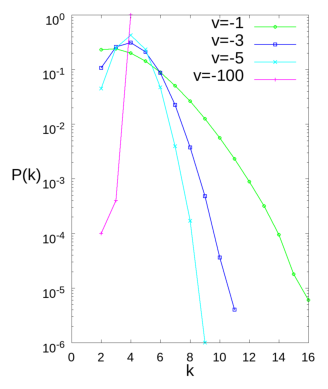

In [6]:
# PNG画像の読み込み
image_path = f"/home/guest/o_t_hayashilab/Network_data/graph-tool/modular_structure/P(k)_m0={M}.png"  # 画像のパスを指定してください
image = mpimg.imread(image_path)

# 画像の表示
plt.imshow(image)
plt.axis('off')  # 軸を非表示にする
plt.show()